In [213]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tabulate import tabulate
import pandas as pd
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from collections import Counter
from mpl_toolkits.mplot3d import Axes3D 

# 1) Сформувати тестову вибірку зображень з вихідного пакету

In [200]:
sample_size = 250
my_number = 9

sample_images = []

# creating a sample of images of given sample_size
while len(sample_images) != sample_size:
    rand_index = random.randint(my_number, 25000)
    image_name = f'im{rand_index}.jpg'
    image = cv2.imread(f'./images/{image_name}')[:, :, 1] # reading only G-channels of RGB images
    sample_images.append((image_name, image))

im1208.jpg


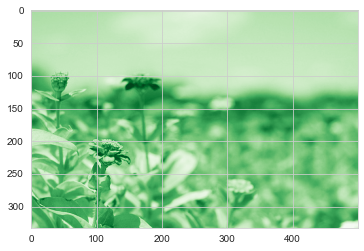

In [201]:
#example of sample image
print(sample_images[0][0])
plt.imshow(sample_images[0][1], cmap='Greens_r');

# 2) Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
 - Математичне очікування та дисперсію
 - Медіану та інтерквартильний розмах
 - Коефіцієнти асиметрії та ексцесу (нормалізований)
 - Гістограму значень яскравості пікселів (нормалізовану)

### Характеристики розподілу:

In [202]:
def distribution_characteristics(image):
    _mathExp = np.mean(image)
    _variance = np.var(image)
    _median = np.median(image)
    _iqr = iqr(image)
    _kurtosis = kurtosis(image.reshape(-1))
    _skew = skew(image.reshape(-1))
    return _mathExp, _variance, _median, _iqr, _kurtosis, _skew

In [203]:
MathExp, Variance, Median, IQR, Kurtosis, Skewness = distribution_characteristics(sample_images[0][1])
print("Math expectancy:", MathExp)
print("Variance:", Variance)
print("Median:", Median)
print("IQR:", IQR)
print("Kurtosis:", Kurtosis)
print("Skewness:", Skewness)

Math expectancy: 145.77944144144143
Variance: 1950.1655701384623
Median: 149.0
IQR: 75.0
Kurtosis: -0.788409049800372
Skewness: -0.4293940904859065


### Гістограма значень яскравості пікселів (нормалізована):

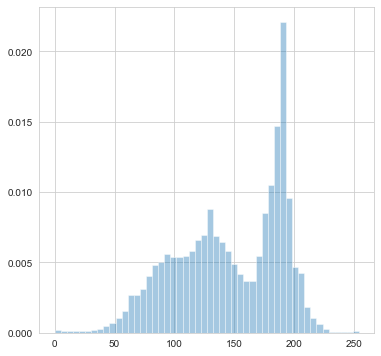

In [204]:
plt.figure(figsize=(6, 6));
sns.distplot(sample_images[0][1], kde=False, norm_hist = True);

# 3) Провести обробку отриманих гістограм:
 - Провести апроксимацію гістограм з використанням імовірнісних розподілів:
     - Нормального (гаусового) розподілу
     - Розподілу Лапласа
     - Розподілу Стьюдента
     - Бета розподілу
 - Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;
 - Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

In [205]:
def plot_hist(image, distribution_name = None):
    f, axes = plt.subplots(1, 2, figsize=(12, 6), sharex=True);
    plt.figure(figsize=(12, 6));
    sns.distplot(image, kde=False, ax=axes[0], norm_hist = True);
    if distribution_name == 'norm':
        sns.distplot(image, kde=False, fit=norm, ax=axes[1]);
    elif distribution_name == 'laplace':
        sns.distplot(image, kde=False, fit=laplace, ax=axes[1]);
    elif distribution_name == 'student':
        sns.distplot(image, kde=False,  fit=t, ax=axes[1]);
    elif distribution_name == 'beta':
        sns.distplot(image, kde=False, fit=beta, ax=axes[1]);
    
    plt.show();

### Апроксимація нормального (гаусового) розподілу

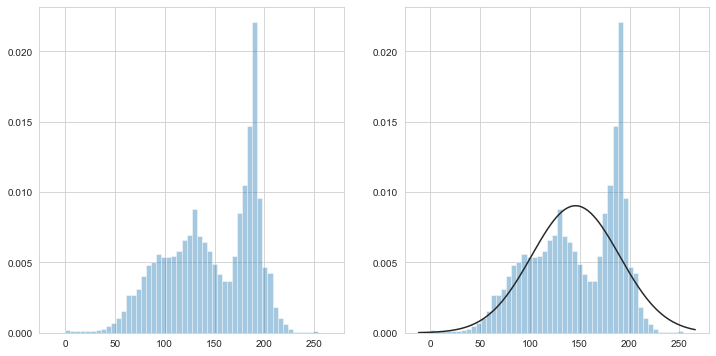

<Figure size 864x432 with 0 Axes>

In [206]:
plot_hist(sample_images[0][1], 'norm');

### Апроксимація лапласового розподілу

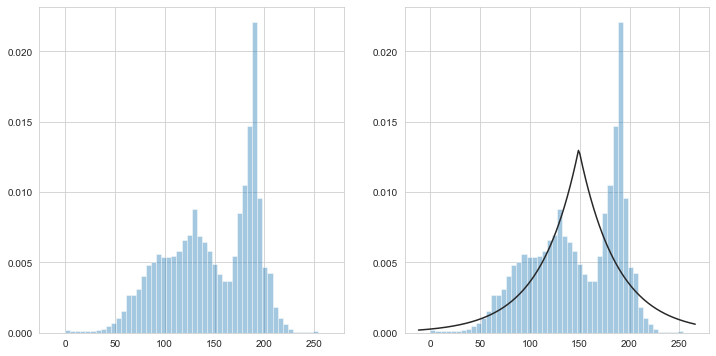

<Figure size 864x432 with 0 Axes>

In [207]:
plot_hist(sample_images[0][1], 'laplace');

### Апроксимація розподілу стьюдента

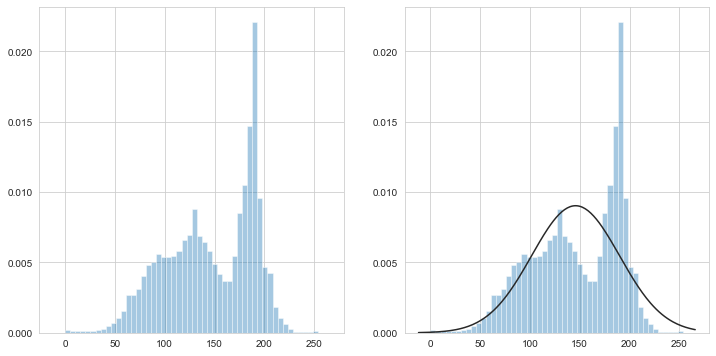

<Figure size 864x432 with 0 Axes>

In [208]:
plot_hist(sample_images[0][1], 'student');

### Апроксимація бета-розподілу

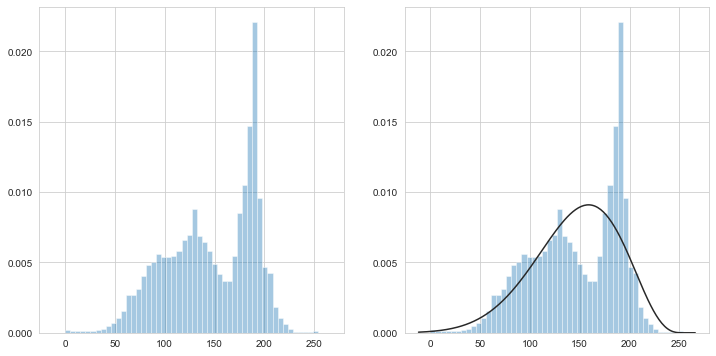

<Figure size 864x432 with 0 Axes>

In [209]:
plot_hist(sample_images[0][1], 'beta');

In [210]:
def find_best_approximation(image):
    bestDistribution = None
    minAvgSqrDeviation = 10**10
    
    # building array of amounts of all pixel brightness values
    arr = []
    max_count = 0
    for i in range(256):
        count = Counter(image)[i]
        arr.append(count)
        if (count > max_count):
            max_count = count    
    # normalizing
    for i in range(256):
        arr[i] /= max_count
        
    space = np.linspace(0,255,num=256)
    for dist in [norm, laplace, t, beta]:
        
        # approximate distribution to data
        params = dist.fit(image)

        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate approximated PDF
        pdf = dist.pdf(space, loc=loc, scale=scale, *arg)
        
        # Find average squared deviation of actual data and approximated PDF values
        avgSqrDeviation = np.sum(np.power(arr - pdf, 2.0))
            
        if avgSqrDeviation <= minAvgSqrDeviation:
            minAvgSqrDeviation = avgSqrDeviation
            bestDistribution = dist
            

    bestDistributionName = ''
    if(bestDistribution == norm):
        bestDistributionName = 'norm'
    elif(bestDistribution == t):
        bestDistributionName = 'student'
    elif(bestDistribution == laplace):
        bestDistributionName = 'laplace'
    elif(bestDistribution == beta):
        bestDistributionName = 'beta'
            
    bestDistributionName
    return bestDistribution, minAvgSqrDeviation, bestDistributionName

In [211]:
def describe_image(image):
    MathExp, Variance, Median, IQR, Kurtosis, Skewness = distribution_characteristics(image)
    print("Math expectancy:", MathExp)
    print("Variance:", Variance)
    print("Median:", Median)
    print("IQR:", IQR)
    print("Kurtosis:", Kurtosis)
    print("Skewness:", Skewness)
    
    bestDistribution, avgSqrDeviation, bestDistributionName = find_best_approximation(image)
    print('=========== distribution approximation =========')
    print('distribution : ', bestDistributionName)
    print('squared error : ', avgSqrDeviation)
    
    print('=========== Plotting graph =========')
    plot_hist(image, bestDistribution)

In [214]:
# example
n_samples = 3
for index in np.random.choice(250, n_samples):
    print(index)
    print(sample_images[index][0])
    describe_image(sample_images[index][1])
    print('******************************************************'*2)

37
im11285.jpg
Math expectancy: 104.99858133333333
Variance: 1855.476179320718
Median: 103.0
IQR: 61.0
Kurtosis: -0.6504457318802861
Skewness: 0.17827782995582778


TypeError: unhashable type: 'numpy.ndarray'

# Побудувати багатовимірні гаусові моделі
Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень:
 - Математичне очікування
 - Математичне очікування та дисперсія
 - Математичне очікування, дисперсія та коефіцієнт асиметрії
 - Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу

In [215]:
def group_statistics(data):
    math_exp_arr = []
    var_arr = []
    skew_arr = []
    kurt_arr = []
    for image in data:
        image_stats = distribution_characteristics(image[1])
        math_exp_arr.append(image_stats[0])
        var_arr.append(image_stats[1])
        skew_arr.append(image_stats[4])
        kurt_arr.append(image_stats[5])
    return math_exp_arr, var_arr, skew_arr, kurt_arr

In [216]:
math_exp, var, skew, kurt = group_statistics(sample_images)

### Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

mean_vec:  102.50769443804532
cov_matrix: 
 1617.7335647970372


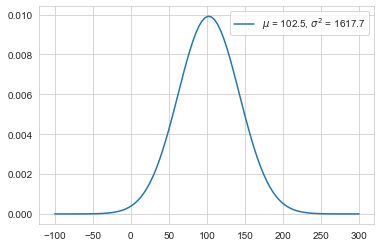

In [217]:
# 1. Math exp 
sample = math_exp
mean_vec_1 = np.mean(sample)
cov_matrix_1 = np.cov(sample)
print('mean_vec: ', mean_vec_1)
print('cov_matrix: \n', cov_matrix_1) 

x = np.linspace(start = -100, stop = 300, num = 100)
y = norm(mean_vec_1, np.sqrt(cov_matrix_1)).pdf(x)
plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(np.round(mean_vec_1, 1), np.round(cov_matrix_1, 1)))
plt.legend();

In [ ]:
# 2. Math exp, Variance
sample = np.vstack((math_exp, var))
mean_vec_2 = np.mean(sample, axis=1)
cov_matrix_2 = np.cov(sample)
print('mean_vec: ', *mean_vec_2)
print('cov_matrix: \n', cov_matrix_2) 


x, y = np.mgrid[-500:3000, -1000:10000]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y
z = multivariate_normal(mean_vec_2, cov_matrix_2).pdf(position)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-50, 200)
ax.set_ylim(-1000, 10000)
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

plt.xlim(-50, 200)
plt.ylim(-1000, 10000)
plt.contour(x, y, z)
plt.show()

mean_vec:  102.50769443804532 3872.770822415655
cov_matrix: 
 [[   1617.7335648    12611.29887435]
 [  12611.29887435 4056130.51210554]]


In [ ]:
# 3. Math exp, Variance, Skew
sample = np.vstack((math_exp, var, skew))
mean_vec_3 = np.mean(sample, axis=1)
cov_matrix_3 = np.cov(sample)
print('mean_vec: ', *mean_vec_3)
print('cov_matrix: \n', cov_matrix_3) 

In [ ]:
# 4. Math exp, Variance, Skew, Kurtosis
sample = np.vstack((math_exp, var, skew, kurt))
mean_vec_4 = np.mean(sample, axis=1)
cov_matrix_4 = np.cov(sample)
print('mean_vec: ', *mean_vec_4)
print('cov_matrix: \n', cov_matrix_4)               